=== Masukkan Kebutuhan Anda ===

=== Input Preferensi Pengguna ===
{'budget': 15000000.0, 'job_type': 'pemrograman', 'screen_type': 'ips', 'processor_type': 'ryzen 5', 'weights': {'Processor': 0.4, 'RAM': 0.3, 'Storage': 0.1, 'Price': 0.2}}

=== Data Laptop yang Sesuai Kriteria ===
     Laptop  Processor  RAM  Storage     Price Screen Processor_Type
3  Laptop D          7   16      512  12000000    ips        ryzen 5

=== Matriks Normalisasi ===
   Processor  RAM  Storage  Price
3        1.0  1.0      1.0    1.0

=== Skor Fuzzy SAW ===
     Laptop  Fuzzy_SAW_Score
3  Laptop D              0.0

=== Bobot Optimal dari PSO ===
{'Processor': 0.02386630104620012, 'RAM': 0.3585119539160452, 'Storage': 0.29344293316097875, 'Price': 0.3241788118767761}

=== Hasil Rekomendasi Laptop dengan Link Pembelian ===
     Laptop  Final_Score                         Link
3  Laptop D          1.0  https://tokopedia.com/linkd

=== Tahap 6: Visualisasi Hasil Rekomendasi ===
Menampilkan visualisasi skor reko

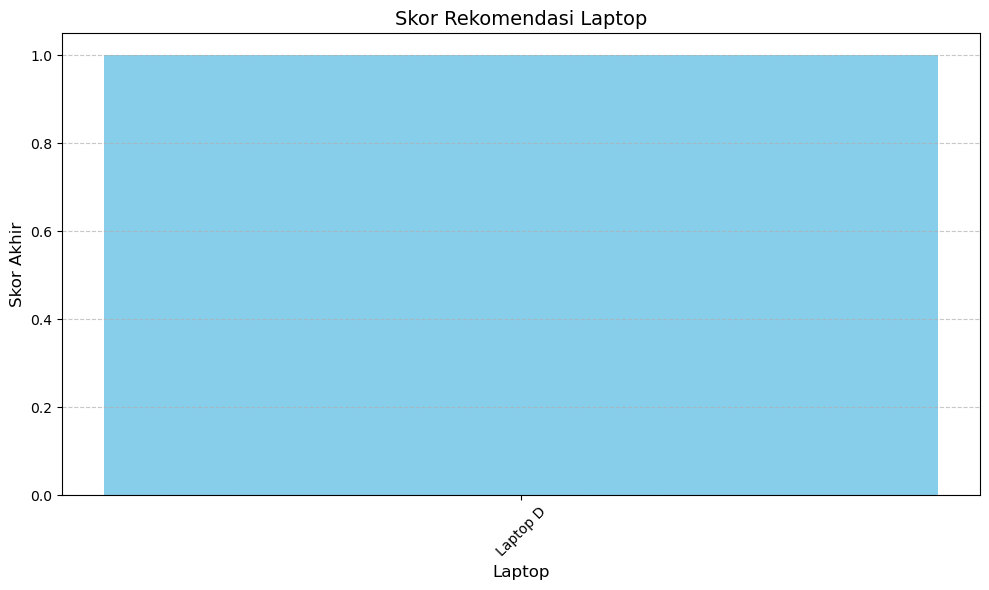

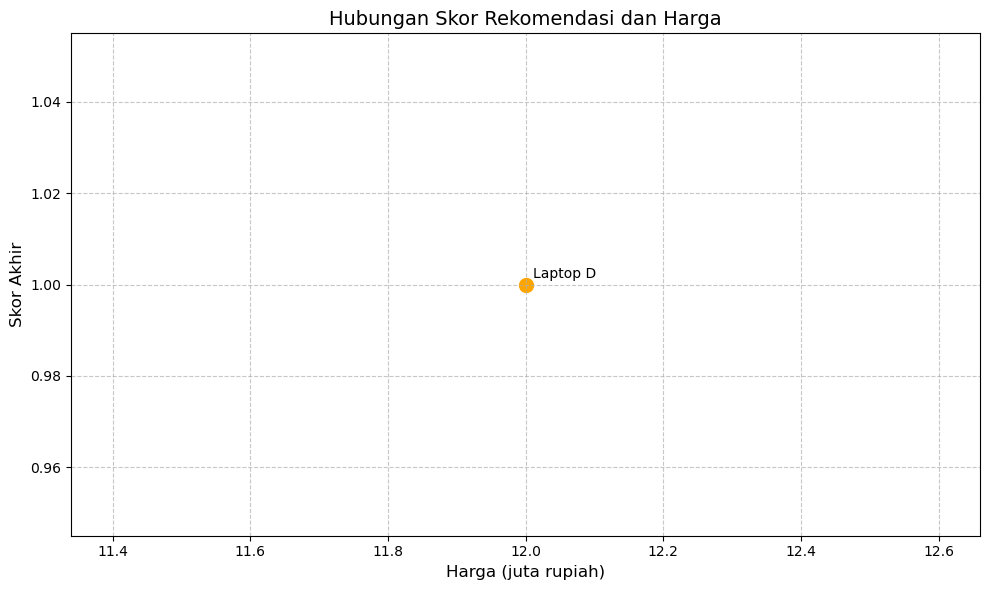

In [6]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Fungsi untuk menampilkan hasil setiap tahap
def print_step(title, data):
    print(f"\n=== {title} ===")
    print(data)

# --- Tahap 1: Pengguna Memasukkan Kebutuhan Spesifikasi Laptop ---
def get_user_input():
    print("=== Masukkan Kebutuhan Anda ===")
    budget = float(input("Budget (dalam juta rupiah, misalnya 15 untuk 15 juta): "))
    job_type = input("Jenis pekerjaan (desain grafis/pemrograman/kantor/hiburan): ").lower()
    screen_type = input("Jenis layar (IPS/OLED/TN): ").lower()
    processor_type = input("Jenis prosesor (Intel i3/Intel i5/Intel i7/Ryzen 5/Ryzen 7): ").lower()
    
    # Tentukan bobot otomatis berdasarkan jenis pekerjaan
    if job_type == "desain grafis":
        weights = {'Processor': 0.3, 'RAM': 0.4, 'Storage': 0.1, 'Price': 0.2}
    elif job_type == "pemrograman":
        weights = {'Processor': 0.4, 'RAM': 0.3, 'Storage': 0.1, 'Price': 0.2}
    elif job_type == "kantor":
        weights = {'Processor': 0.2, 'RAM': 0.2, 'Storage': 0.2, 'Price': 0.4}
    else:  # hiburan
        weights = {'Processor': 0.25, 'RAM': 0.25, 'Storage': 0.25, 'Price': 0.25}
    
    preferences = {
        'budget': budget * 1000000,  # Konversi ke rupiah
        'job_type': job_type,
        'screen_type': screen_type,
        'processor_type': processor_type,
        'weights': weights
    }
    return preferences

user_preferences = get_user_input()
print_step("Input Preferensi Pengguna", user_preferences)

# Data dummy laptop (disesuaikan dengan input pengguna)
laptops = pd.DataFrame({
    'Laptop': ['Laptop A', 'Laptop B', 'Laptop C', 'Laptop D', 'Laptop E'],
    'Processor': [8, 6, 10, 7, 9],  # Skor prosesor (1-10)
    'RAM': [16, 8, 32, 16, 4],      # GB
    'Storage': [512, 256, 1000, 512, 128],  # GB
    'Price': [10000000, 8000000, 15000000, 12000000, 6000000],  # Rupiah
    'Screen': ['ips', 'tn', 'oled', 'ips', 'tn'],
    'Processor_Type': ['intel i5', 'intel i3', 'intel i7', 'ryzen 5', 'intel i3']
})
# Filter berdasarkan input pengguna
laptops = laptops[
    (laptops['Price'] <= user_preferences['budget']) &
    (laptops['Screen'].str.lower() == user_preferences['screen_type']) &
    (laptops['Processor_Type'].str.lower() == user_preferences['processor_type'])
]
if laptops.empty:
    print("Tidak ada laptop yang sesuai dengan kriteria Anda!")
    exit()
print_step("Data Laptop yang Sesuai Kriteria", laptops)

# --- Tahap 2: Melakukan Pembobotan Input Spesifikasi ---
normalized = laptops.copy()
for col in ['Processor', 'RAM', 'Storage']:
    normalized[col] = laptops[col] / laptops[col].max()
normalized['Price'] = laptops['Price'].min() / laptops['Price']
print_step("Matriks Normalisasi", normalized[['Processor', 'RAM', 'Storage', 'Price']])

# --- Tahap 3: Hitung Penilaian dengan Fuzzy SAW ---
def fuzzy_membership(value, a, b, c):
    if value <= a:
        return 0
    elif a < value <= b:
        return (value - a) / (b - a)
    elif b < value <= c:
        return (c - value) / (c - b)
    else:
        return 0

fuzzy_scores = []
for i, row in normalized.iterrows():
    score = 0
    for crit, weight in user_preferences['weights'].items():
        fuzzy_val = fuzzy_membership(row[crit], 0, 0.5, 1)
        crisp_val = fuzzy_val * weight
        score += crisp_val
    fuzzy_scores.append(score)

laptops['Fuzzy_SAW_Score'] = fuzzy_scores
print_step("Skor Fuzzy SAW", laptops[['Laptop', 'Fuzzy_SAW_Score']])

# --- Tahap 4: Optimasi dengan PSO ---
n_particles = 10
n_iterations = 20
w = 0.7
c1 = 1.5
c2 = 1.5

particles = np.random.rand(n_particles, 4)
velocities = np.zeros((n_particles, 4))
pbest = particles.copy()
pbest_scores = np.zeros(n_particles)
gbest = None
gbest_score = -np.inf

def compute_fitness(particle, data):
    norm_weights = particle / particle.sum()
    scores = np.dot(data, norm_weights)
    return np.max(scores)

for _ in range(n_iterations):
    for i in range(n_particles):
        fitness = compute_fitness(particles[i], normalized[['Processor', 'RAM', 'Storage', 'Price']].values)
        if fitness > pbest_scores[i]:
            pbest_scores[i] = fitness
            pbest[i] = particles[i].copy()
        if fitness > gbest_score:
            gbest_score = fitness
            gbest = particles[i].copy()
    for i in range(n_particles):
        r1, r2 = np.random.rand(2)
        velocities[i] = (w * velocities[i] + 
                         c1 * r1 * (pbest[i] - particles[i]) + 
                         c2 * r2 * (gbest - particles[i]))
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], 0, 1)

optimal_weights = gbest / gbest.sum()
print_step("Bobot Optimal dari PSO", dict(zip(user_preferences['weights'].keys(), optimal_weights)))

# --- Tahap 5: Hasil Rekomendasi Laptop ---
final_scores = np.dot(normalized[['Processor', 'RAM', 'Storage', 'Price']].values, optimal_weights)
laptops['Final_Score'] = final_scores
laptops_sorted = laptops.sort_values(by='Final_Score', ascending=False)
laptops_sorted['Link'] = [f"https://tokopedia.com/link{laptop[-1].lower()}" for laptop in laptops_sorted['Laptop']]
print_step("Hasil Rekomendasi Laptop dengan Link Pembelian", laptops_sorted[['Laptop', 'Final_Score', 'Link']])

# --- Tahap 6: Visualisasi Hasil Rekomendasi ---
print_step("Tahap 6: Visualisasi Hasil Rekomendasi", "Menampilkan visualisasi skor rekomendasi")

# Bar Chart untuk skor akhir
plt.figure(figsize=(10, 6))
plt.bar(laptops_sorted['Laptop'], laptops_sorted['Final_Score'], color='skyblue')
plt.title('Skor Rekomendasi Laptop', fontsize=14)
plt.xlabel('Laptop', fontsize=12)
plt.ylabel('Skor Akhir', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Scatter Plot: Skor vs Harga
plt.figure(figsize=(10, 6))
plt.scatter(laptops_sorted['Price'] / 1000000, laptops_sorted['Final_Score'], color='orange', s=100)
for i, txt in enumerate(laptops_sorted['Laptop']):
    plt.annotate(txt, (laptops_sorted['Price'].iloc[i] / 1000000, laptops_sorted['Final_Score'].iloc[i]), xytext=(5, 5), textcoords='offset points')
plt.title('Hubungan Skor Rekomendasi dan Harga', fontsize=14)
plt.xlabel('Harga (juta rupiah)', fontsize=12)
plt.ylabel('Skor Akhir', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import numpy as np

# Tentukan jumlah laptop
n_laptops = 1000

# Tentukan rentang nilai
processor_scores = np.random.randint(1, 11, n_laptops)
ram_options = [4, 8, 16, 32, 64]
ram_values = np.random.choice(ram_options, n_laptops)
storage_options = [128, 256, 512, 1000, 2000]
storage_values = np.random.choice(storage_options, n_laptops)
price_values = np.random.randint(5000000, 30000001, n_laptops)
screen_options = ['ips', 'tn', 'oled']
screen_values = np.random.choice(screen_options, n_laptops)
processor_type_options = ['intel i3', 'intel i5', 'intel i7', 'ryzen 5', 'ryzen 7']
processor_type_values = np.random.choice(processor_type_options, n_laptops)
screen_size_options = [13.3, 14.0, 15.6]
screen_size_values = np.random.choice(screen_size_options, n_laptops)
weight_values = np.round(np.random.uniform(1.0, 3.0, n_laptops), 1)
battery_life_values = np.random.randint(4, 12, n_laptops)
gpu_options = ['low', 'mid', 'high']
gpu_values = np.random.choice(gpu_options, n_laptops)

# Buat DataFrame
laptops = pd.DataFrame({
    'Laptop': [f'Laptop {i+1}' for i in range(n_laptops)],
    'Processor': processor_scores,
    'RAM': ram_values,
    'Storage': storage_values,
    'Price': price_values,
    'Screen': screen_values,
    'Processor_Type': processor_type_values,
    'Screen_Size': screen_size_values,
    'Weight': weight_values,
    'Battery_Life': battery_life_values,
    'GPU_Type': gpu_values
})

# Simpan ke Excel
laptops.to_excel('laptops_dummy.xlsx', index=False)
print("Data dummy laptop telah disimpan ke 'laptops_dummy.xlsx'")


Data dummy laptop telah disimpan ke 'laptops_dummy.xlsx'
